# CS231a PSET 3 Problem 2: Representation Learning with Self-Supervised Learning


# Overview

In this notebook we will be using the [Fashion MNIST dataset](https://github.com/zalandoresearch/fashion-mnist), a variation on the classic [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database), to showcase how self-supervised representation learning can be utilized for more efficient training in downstream tasks. We will do the following things:

1. Train a classifier from scratch on the Fashion MNIST dataset and observe how fast and well it learns.

2. Train useful representations via predicting image rotations, rather than classifying clothing types.

3. Transfer our rotation pretraining features to solve the classification task with much less data than in step 1.

First, you should upload the files in 'code/p2' directory onto a location of your choosing in Drive and run the following to have access to them. You can also skip this step and just upload the files directly using the files tab, though any changes you make will be gone if you close the tab or the colab runtime ends.

In [2]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# Enter the foldername in your Drive where you have saved the unzipped
# '.py' files from the p2 folder
# e.g. 'cs231a/pset3/p2'
FOLDERNAME = 'pset_3/problem2'

assert FOLDERNAME is not None, "[!] Enter the foldername."

%cd drive/My\ Drive
# print(f'This is folder name {FOLDERNAME}')
%cd $FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive
/content/drive/My Drive/pset_3/problem2


You should now be able to click on the folder icon to the left and see a folder that says 'drive' above a folder that says 'sample_data'. Open it, go to MyDrive, and then navigate to where you put the files. You can double click on any .py file to modify it within this Colab notebook, and we recommend you work on these problems using that. Let's confirm the files are uploaded and accessible:

In [4]:
import import_test

Import works!


If the above import of works, you are ready to get going with the rest of this problem! Before that, let's make sure you allocate a GPU so that code runs faster: click Runtime -> Change runtime type -> Hardware Accelerator -> GPU and your Colab instance will automatically be backed by GPU compute.

# Fashion MNIST Data Preparation

First, let's get the data prepared. Luckily, PyTorch has a handy function to download it for us in its [torchvision.datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar) package. Go ahead and get the 
required torchvision version by running the following; you'll only need to do so once, and then click Runtime->Restart runtime to move on. Every time you restart the runtime, you'll need to re-run everything.

In [5]:
!pip install torchvision==0.2.1 #need this version to get processed data

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 KB 5.6 MB/s eta 0:00:00
Reason for being yanked: So that users won't accidentally install this when using python 3.11
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.14.1+cu116
    Uninstalling torchvision-0.14.1+cu116:
      Successfully uninstalled torchvision-0.14.1+cu116
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.11 requires torchvision>=0.8.2, but you have torchvision 0.2.1 which is incompatible.


Now we can go ahead and get the data:

In [6]:
# Download Fashion MNIST dataset from PyTorch 
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
                              transforms.Resize((32,32)),
                              transforms.ToTensor(),
                              ])
PATH_TO_STORE_DATA = 'problem2/data/'
dataset_train = torchvision.datasets.FashionMNIST(PATH_TO_STORE_DATA, download=True, train=True, 
                                             transform=transform)
dataset_test = torchvision.datasets.FashionMNIST(PATH_TO_STORE_DATA, download=True, train=False, 
                                            transform=transform)

Now that we have downloaded the data, we will implement a PyTorch [Dataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) so that we can load subsets of the full Fashion MNIST dataset and use either clothing type or image rotation as the label for a given image. Fill in the requisite bits of code in data.py marked with TODO (you can either do so directly through the file explorer on the left or do so locally and re-upload it), and try to execute the following:

In [7]:
from importlib import reload  
import data 

Now, let's create an instance of this Dataset for training Fashion MNIST  classification. We will create two versions of the training dataset, one with all the data and one with a small subset. If you have bugs in your code, simply modify data.py and re-run this bit.

In [8]:
data = reload(data) #reload for making changes during debugging
train_full_dataset = data.MNISTDatasetWrapper(dataset_train, pct=1.0)
test_full_dataset = data.MNISTDatasetWrapper(dataset_test, pct=1.0)
print('Full dataset: {0} Training Samples | {1} Test Samples'.format(
    len(train_full_dataset), len(test_full_dataset)))

train_small_dataset = data.MNISTDatasetWrapper(dataset_train, pct=0.05)
print('Small train dataset: {0} Training Samples'.format(len(train_small_dataset)))

Full dataset: 60000 Training Samples | 10000 Test Samples
Small train dataset: 60000 Training Samples


Let's use the handy show_batch function to get an idea of what's in the dataset:

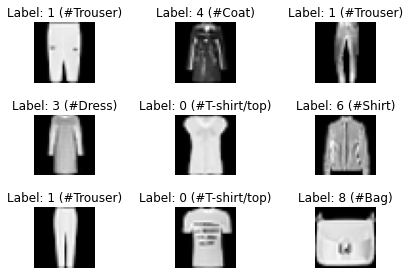

In [13]:
train_full_dataset.show_batch()

# PyTorch Vision Model

Next, we need to define our neural net architectures for training on the data. Because we want to ultimately train for two objectives (clothing type classification and rotation classification), we will do this via several classes so that the weights gotten from representation learning can be re-used later for more efficient clothing classification.
Fill in the marked portions of models.py, and try to execute the following:

In [14]:
import models
models = reload(models) #reload for making changes during debugging

image_embed_net = models.ImageEmbedNet().cuda()
classify_net = models.ClassifyNet(10).cuda()
mnist_classify_model = models.ImageClassifyModel(image_embed_net, classify_net)


If running the above results in errors, revise your code in models.py and re-run as before.

# Training for Fashion MNIST Class Prediction

Let's now implement a method for training on the dataset with the model we defined above. We will create a re-usable function that can be used for both representation learning and learning to classify Fashion MNIST images. This will involve the following:
*   Given the dataset, creating a PyTorch [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) which can take care of shuffling the dataset as well as combining multiple image.
*   Creating a PyTorch loss function that can be used for optimizing our model for the task of classification. We will use the standard [Cross Entropy Loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).
*   Creating a PyTorch [optimizer](https://pytorch.org/docs/stable/optim.html) to update the weights of the model given the loss computation.
*   Lastly, our two training loops (one for the number of epochs, and one for iterating over the dataset) in which we use all the above to train the model.

Fill in the relevant portions of code in training.py, and try to execute the following to go ahead and train on the Fashion MNIST classification task. If training.py is finished, we now just need to call its train function:

Training for one epoch: 100%|██████████| 3750/3750 [00:22<00:00, 166.24it/s]


Epoch 0 - Training loss: 2.311 , Training Accuracy: 0.092



Training for one epoch: 100%|██████████| 3750/3750 [00:21<00:00, 176.09it/s]


Epoch 1 - Training loss: 0.710 , Training Accuracy: 0.739



Training for one epoch: 100%|██████████| 3750/3750 [00:19<00:00, 195.12it/s]


Epoch 2 - Training loss: 0.403 , Training Accuracy: 0.854



Training for one epoch: 100%|██████████| 3750/3750 [00:20<00:00, 183.78it/s]


Epoch 3 - Training loss: 0.337 , Training Accuracy: 0.877



Training for one epoch: 100%|██████████| 3750/3750 [00:19<00:00, 192.34it/s]


Epoch 4 - Training loss: 0.302 , Training Accuracy: 0.890



Training for one epoch: 100%|██████████| 3750/3750 [00:20<00:00, 184.91it/s]


Epoch 5 - Training loss: 0.276 , Training Accuracy: 0.898



Training for one epoch: 100%|██████████| 3750/3750 [00:19<00:00, 192.52it/s]


Epoch 6 - Training loss: 0.258 , Training Accuracy: 0.904



Training for one epoch: 100%|██████████| 3750/3750 [00:20<00:00, 184.78it/s]


Epoch 7 - Training loss: 0.242 , Training Accuracy: 0.910



Training for one epoch: 100%|██████████| 3750/3750 [00:19<00:00, 191.88it/s]


Epoch 8 - Training loss: 0.230 , Training Accuracy: 0.915



Training for one epoch: 100%|██████████| 3750/3750 [00:20<00:00, 184.04it/s]


Epoch 9 - Training loss: 0.219 , Training Accuracy: 0.919



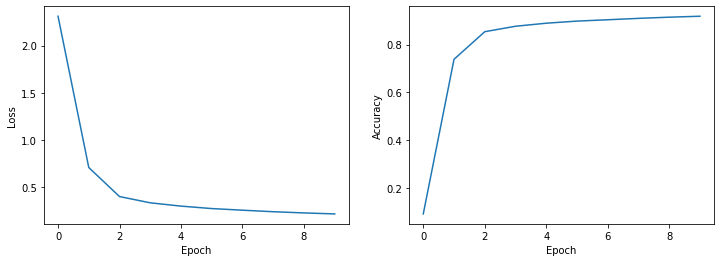

In [15]:
import training

training = reload(training)
# Create fresh model before every run to make sure we start from scratch
image_embed_net = models.ImageEmbedNet().cuda()
classify_net = models.ClassifyNet(10).cuda()
mnist_classify_model = models.ImageClassifyModel(image_embed_net, 
                                                          classify_net)

training.train(train_full_dataset, mnist_classify_model, 16, 10)

You should get training accuracy of around 0.92. With the model now trained, let's implement a test function and call it to see how well it works on the test set. Finish the marked portions in testing.py and run the following:

In [16]:
import testing

testing = reload(testing)
testing.test(test_full_dataset, mnist_classify_model, 16)

Testing Accuracy: 0.897


You should get test set accuracy slighty lower than the train set accuracy. The accuracy is not great; on such simple data it should be fairly easy to get close to perfect accuracy. We'll try to address this with representation learning.

Before that, let's try training on the smaller train set, and see how well the model can work on the test set.

Training for one epoch: 100%|██████████| 3750/3750 [00:14<00:00, 252.26it/s]


Epoch 0 - Training loss: 2.310 , Training Accuracy: 0.100



Training for one epoch: 100%|██████████| 3750/3750 [00:20<00:00, 185.00it/s]


Epoch 1 - Training loss: 0.751 , Training Accuracy: 0.723



Training for one epoch: 100%|██████████| 3750/3750 [00:20<00:00, 186.93it/s]


Epoch 2 - Training loss: 0.408 , Training Accuracy: 0.853



Training for one epoch: 100%|██████████| 3750/3750 [00:20<00:00, 180.78it/s]


Epoch 3 - Training loss: 0.343 , Training Accuracy: 0.875



Training for one epoch: 100%|██████████| 3750/3750 [00:20<00:00, 185.18it/s]


Epoch 4 - Training loss: 0.304 , Training Accuracy: 0.888



Training for one epoch: 100%|██████████| 3750/3750 [00:20<00:00, 184.52it/s]


Epoch 5 - Training loss: 0.281 , Training Accuracy: 0.897



Training for one epoch: 100%|██████████| 3750/3750 [00:20<00:00, 185.65it/s]


Epoch 6 - Training loss: 0.261 , Training Accuracy: 0.903



Training for one epoch: 100%|██████████| 3750/3750 [00:20<00:00, 181.32it/s]


Epoch 7 - Training loss: 0.246 , Training Accuracy: 0.909



Training for one epoch: 100%|██████████| 3750/3750 [00:19<00:00, 189.51it/s]


Epoch 8 - Training loss: 0.233 , Training Accuracy: 0.914



Training for one epoch: 100%|██████████| 3750/3750 [00:20<00:00, 180.27it/s]


Epoch 9 - Training loss: 0.222 , Training Accuracy: 0.918



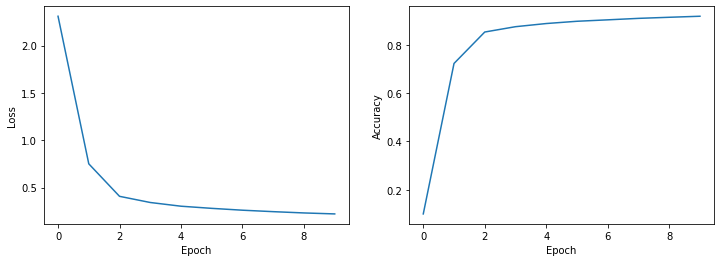

Testing Accuracy: 0.898


In [ ]:
image_embed_net = models.ImageEmbedNet().cuda()
classify_net = models.ClassifyNet(10).cuda()
mnist_classify_model = models.ImageClassifyModel(image_embed_net, classify_net)
training.train(train_small_dataset, mnist_classify_model, 16, 10)
testing.test(test_full_dataset, mnist_classify_model, 16)

You should get both lower training and testing accuracy, since we are not training with much less data. If we iterate over the data for more epochs it is possible to get better results, but still below the accuracy gotten with the full dataset:

# Representation Learning via Rotation Classification


Now, let's define new datasets for doing our representation learning by predicting the rotation of Fashion MNIST images, and once again call show_batch to get a look at the data:

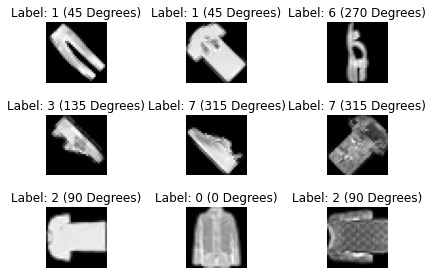

In [17]:
data = reload(data) #reload for making changes during debugging

train_rotation_dataset = data.MNISTDatasetWrapper(dataset_train, 
                                          pct=1.0, for_rotation_classification=True)
test_rotation_dataset = data.MNISTDatasetWrapper(dataset_test, 
                                         pct=1.0, for_rotation_classification=True)
train_rotation_dataset.show_batch()

Now, let's train a model on the rotation prediction task by once again using our train function:

Training for one epoch: 100%|██████████| 3750/3750 [00:26<00:00, 140.04it/s]


Epoch 0 - Training loss: 2.087 , Training Accuracy: 0.128



Training for one epoch: 100%|██████████| 3750/3750 [00:32<00:00, 117.06it/s]


Epoch 1 - Training loss: 0.765 , Training Accuracy: 0.722



Training for one epoch: 100%|██████████| 3750/3750 [00:32<00:00, 114.97it/s]


Epoch 2 - Training loss: 0.249 , Training Accuracy: 0.915



Training for one epoch: 100%|██████████| 3750/3750 [00:31<00:00, 118.36it/s]


Epoch 3 - Training loss: 0.171 , Training Accuracy: 0.944



Training for one epoch: 100%|██████████| 3750/3750 [00:32<00:00, 116.94it/s]


Epoch 4 - Training loss: 0.140 , Training Accuracy: 0.955



Training for one epoch: 100%|██████████| 3750/3750 [00:34<00:00, 108.91it/s]


Epoch 5 - Training loss: 0.119 , Training Accuracy: 0.962



Training for one epoch: 100%|██████████| 3750/3750 [00:31<00:00, 118.87it/s]


Epoch 6 - Training loss: 0.106 , Training Accuracy: 0.966



Training for one epoch: 100%|██████████| 3750/3750 [00:31<00:00, 118.57it/s]


Epoch 7 - Training loss: 0.096 , Training Accuracy: 0.970



Training for one epoch: 100%|██████████| 3750/3750 [00:33<00:00, 113.14it/s]


Epoch 8 - Training loss: 0.089 , Training Accuracy: 0.972



Training for one epoch: 100%|██████████| 3750/3750 [00:32<00:00, 116.91it/s]


Epoch 9 - Training loss: 0.084 , Training Accuracy: 0.972



Training for one epoch: 100%|██████████| 3750/3750 [00:33<00:00, 110.69it/s]


Epoch 10 - Training loss: 0.078 , Training Accuracy: 0.975



Training for one epoch: 100%|██████████| 3750/3750 [00:33<00:00, 113.55it/s]


Epoch 11 - Training loss: 0.075 , Training Accuracy: 0.976



Training for one epoch: 100%|██████████| 3750/3750 [00:32<00:00, 115.33it/s]


Epoch 12 - Training loss: 0.071 , Training Accuracy: 0.977



Training for one epoch: 100%|██████████| 3750/3750 [00:32<00:00, 115.21it/s]


Epoch 13 - Training loss: 0.067 , Training Accuracy: 0.978



Training for one epoch: 100%|██████████| 3750/3750 [00:31<00:00, 118.35it/s]


Epoch 14 - Training loss: 0.064 , Training Accuracy: 0.979



Training for one epoch: 100%|██████████| 3750/3750 [00:33<00:00, 113.13it/s]


Epoch 15 - Training loss: 0.063 , Training Accuracy: 0.980



Training for one epoch: 100%|██████████| 3750/3750 [00:32<00:00, 114.16it/s]


Epoch 16 - Training loss: 0.059 , Training Accuracy: 0.980



Training for one epoch: 100%|██████████| 3750/3750 [00:33<00:00, 111.90it/s]


Epoch 17 - Training loss: 0.060 , Training Accuracy: 0.980



Training for one epoch: 100%|██████████| 3750/3750 [00:32<00:00, 116.24it/s]


Epoch 18 - Training loss: 0.056 , Training Accuracy: 0.981



Training for one epoch: 100%|██████████| 3750/3750 [00:31<00:00, 117.43it/s]


Epoch 19 - Training loss: 0.053 , Training Accuracy: 0.983



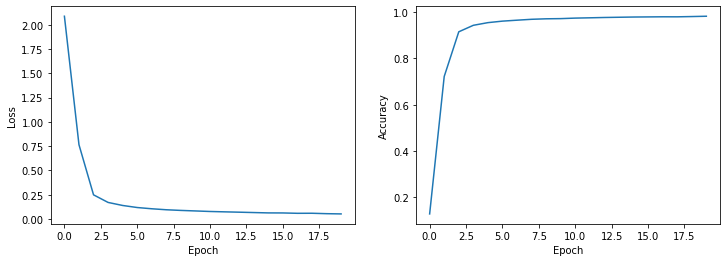

In [18]:
rotation_image_embed_net = models.ImageEmbedNet().cuda()
rotation_classify_net = models.ClassifyNet(8).cuda()
mnist_rotation_classify_model = models.ImageClassifyModel(rotation_image_embed_net, 
                                                   rotation_classify_net)
training.train(train_rotation_dataset, mnist_rotation_classify_model, 16, 20)

As you should see, the network manages to get quite good at predicting rotations, with around 0.98 accuracy.




We should once again get testing accuracy similar to training accuracy (around 0.98):

In [19]:
testing.test(test_rotation_dataset, mnist_rotation_classify_model, 16)

Testing Accuracy: 0.983


# Fine-Tuning for Fashion MNIST classification

Now that we have pretrained our model on the rotation prediction task, let's reuse the image embed part of it to train it for the task of class classification. We will use load_state_dict to transfer over the weights from the trained model to a new instance of it, so we can later re-use the same representation learning weights in a different setup. Let's first try it on the full dataset and see how fast it converges compared to when we did not pretrain it.

Training for one epoch: 100%|██████████| 3750/3750 [00:14<00:00, 252.81it/s]


Epoch 0 - Training loss: 2.324 , Training Accuracy: 0.037



Training for one epoch: 100%|██████████| 3750/3750 [00:20<00:00, 187.00it/s]


Epoch 1 - Training loss: 0.466 , Training Accuracy: 0.831



Training for one epoch: 100%|██████████| 3750/3750 [00:21<00:00, 178.32it/s]


Epoch 2 - Training loss: 0.301 , Training Accuracy: 0.893



Training for one epoch: 100%|██████████| 3750/3750 [00:19<00:00, 189.37it/s]


Epoch 3 - Training loss: 0.264 , Training Accuracy: 0.903



Training for one epoch: 100%|██████████| 3750/3750 [00:20<00:00, 181.60it/s]


Epoch 4 - Training loss: 0.241 , Training Accuracy: 0.912



Training for one epoch: 100%|██████████| 3750/3750 [00:20<00:00, 184.57it/s]


Epoch 5 - Training loss: 0.225 , Training Accuracy: 0.917



Training for one epoch: 100%|██████████| 3750/3750 [00:20<00:00, 185.07it/s]


Epoch 6 - Training loss: 0.212 , Training Accuracy: 0.922



Training for one epoch: 100%|██████████| 3750/3750 [00:19<00:00, 190.60it/s]


Epoch 7 - Training loss: 0.199 , Training Accuracy: 0.926



Training for one epoch: 100%|██████████| 3750/3750 [00:20<00:00, 183.23it/s]


Epoch 8 - Training loss: 0.190 , Training Accuracy: 0.930



Training for one epoch: 100%|██████████| 3750/3750 [00:20<00:00, 186.85it/s]


Epoch 9 - Training loss: 0.179 , Training Accuracy: 0.933



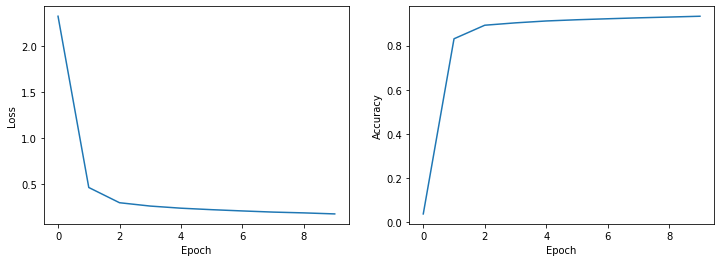

In [ ]:
image_embed_net = models.ImageEmbedNet().cuda()
image_embed_net.load_state_dict(rotation_image_embed_net.state_dict())
classify_net = models.ClassifyNet(10).cuda()
mnist_classify_model = models.ImageClassifyModel(image_embed_net, classify_net)
training.train(train_full_dataset, mnist_classify_model, 16, 10)

In [ ]:
testing.test(test_full_dataset, mnist_classify_model, 16)

Testing Accuracy: 0.910


As we can see, it improves faster and achieves better train and test performance, although the improvement is not huge.

Now, let's try training with the small dataset again and see how well that works:

Training for one epoch: 100%|██████████| 3750/3750 [00:15<00:00, 247.01it/s]


Epoch 0 - Training loss: 2.304 , Training Accuracy: 0.084



Training for one epoch: 100%|██████████| 3750/3750 [00:20<00:00, 184.55it/s]


Epoch 1 - Training loss: 0.464 , Training Accuracy: 0.833



Training for one epoch: 100%|██████████| 3750/3750 [00:20<00:00, 187.01it/s]


Epoch 2 - Training loss: 0.299 , Training Accuracy: 0.891



Training for one epoch: 100%|██████████| 3750/3750 [00:20<00:00, 187.30it/s]


Epoch 3 - Training loss: 0.263 , Training Accuracy: 0.904



Training for one epoch: 100%|██████████| 3750/3750 [00:19<00:00, 188.84it/s]


Epoch 4 - Training loss: 0.242 , Training Accuracy: 0.910



Training for one epoch: 100%|██████████| 3750/3750 [00:20<00:00, 184.96it/s]


Epoch 5 - Training loss: 0.225 , Training Accuracy: 0.917



Training for one epoch: 100%|██████████| 3750/3750 [00:19<00:00, 189.71it/s]


Epoch 6 - Training loss: 0.211 , Training Accuracy: 0.922



Training for one epoch: 100%|██████████| 3750/3750 [00:19<00:00, 187.68it/s]


Epoch 7 - Training loss: 0.200 , Training Accuracy: 0.925



Training for one epoch: 100%|██████████| 3750/3750 [00:19<00:00, 190.71it/s]


Epoch 8 - Training loss: 0.188 , Training Accuracy: 0.930



Training for one epoch: 100%|██████████| 3750/3750 [00:20<00:00, 186.01it/s]


Epoch 9 - Training loss: 0.179 , Training Accuracy: 0.933



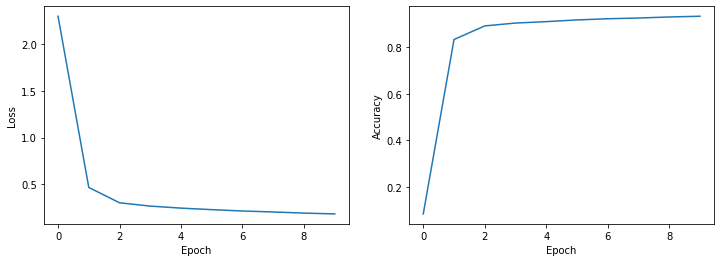

In [ ]:
image_embed_net = models.ImageEmbedNet().cuda()
image_embed_net.load_state_dict(rotation_image_embed_net.state_dict())
classify_net = models.ClassifyNet(10).cuda()
mnist_classify_model = models.ImageClassifyModel(image_embed_net, classify_net)
training.train(train_small_dataset, mnist_classify_model, 16, 10)

In [ ]:
testing.test(test_full_dataset, mnist_classify_model, 16)

Testing Accuracy: 0.907


Now we can see that the with the smaller dataset the pretrained features make a lot of difference, as we get a substantial improvement in training and test accuracy! 

What if we just train for longer? With such a small training dataset, it's possible to achieve perfect accuracy:

Training for one epoch: 100%|██████████| 3750/3750 [00:14<00:00, 256.25it/s]


Epoch 0 - Training loss: 2.316 , Training Accuracy: 0.106



Training for one epoch: 100%|██████████| 3750/3750 [00:20<00:00, 183.91it/s]


Epoch 1 - Training loss: 0.448 , Training Accuracy: 0.838



Training for one epoch: 100%|██████████| 3750/3750 [00:19<00:00, 194.76it/s]


Epoch 2 - Training loss: 0.295 , Training Accuracy: 0.892



Training for one epoch: 100%|██████████| 3750/3750 [00:20<00:00, 182.13it/s]


Epoch 3 - Training loss: 0.261 , Training Accuracy: 0.904



Training for one epoch: 100%|██████████| 3750/3750 [00:19<00:00, 191.62it/s]


Epoch 4 - Training loss: 0.239 , Training Accuracy: 0.911



Training for one epoch: 100%|██████████| 3750/3750 [00:20<00:00, 186.07it/s]


Epoch 5 - Training loss: 0.222 , Training Accuracy: 0.918



Training for one epoch: 100%|██████████| 3750/3750 [00:19<00:00, 192.22it/s]


Epoch 6 - Training loss: 0.209 , Training Accuracy: 0.923



Training for one epoch: 100%|██████████| 3750/3750 [00:20<00:00, 185.97it/s]


Epoch 7 - Training loss: 0.196 , Training Accuracy: 0.928



Training for one epoch: 100%|██████████| 3750/3750 [00:19<00:00, 197.19it/s]


Epoch 8 - Training loss: 0.187 , Training Accuracy: 0.931



Training for one epoch: 100%|██████████| 3750/3750 [00:20<00:00, 185.83it/s]


Epoch 9 - Training loss: 0.177 , Training Accuracy: 0.934



Training for one epoch: 100%|██████████| 3750/3750 [00:19<00:00, 197.35it/s]


Epoch 10 - Training loss: 0.170 , Training Accuracy: 0.937



Training for one epoch: 100%|██████████| 3750/3750 [00:20<00:00, 187.26it/s]


Epoch 11 - Training loss: 0.160 , Training Accuracy: 0.940



Training for one epoch: 100%|██████████| 3750/3750 [00:19<00:00, 195.80it/s]


Epoch 12 - Training loss: 0.154 , Training Accuracy: 0.942



Training for one epoch: 100%|██████████| 3750/3750 [00:20<00:00, 184.19it/s]


Epoch 13 - Training loss: 0.146 , Training Accuracy: 0.945



Training for one epoch: 100%|██████████| 3750/3750 [00:19<00:00, 195.11it/s]


Epoch 14 - Training loss: 0.139 , Training Accuracy: 0.949



Training for one epoch: 100%|██████████| 3750/3750 [00:20<00:00, 182.84it/s]


Epoch 15 - Training loss: 0.131 , Training Accuracy: 0.951



Training for one epoch: 100%|██████████| 3750/3750 [00:19<00:00, 193.47it/s]


Epoch 16 - Training loss: 0.126 , Training Accuracy: 0.953



Training for one epoch: 100%|██████████| 3750/3750 [00:20<00:00, 186.53it/s]


Epoch 17 - Training loss: 0.121 , Training Accuracy: 0.955



Training for one epoch: 100%|██████████| 3750/3750 [00:19<00:00, 193.11it/s]


Epoch 18 - Training loss: 0.115 , Training Accuracy: 0.957



Training for one epoch: 100%|██████████| 3750/3750 [00:20<00:00, 183.71it/s]


Epoch 19 - Training loss: 0.109 , Training Accuracy: 0.959



Training for one epoch: 100%|██████████| 3750/3750 [00:19<00:00, 195.52it/s]


Epoch 20 - Training loss: 0.105 , Training Accuracy: 0.961



Training for one epoch: 100%|██████████| 3750/3750 [00:20<00:00, 185.79it/s]


Epoch 21 - Training loss: 0.099 , Training Accuracy: 0.963



Training for one epoch: 100%|██████████| 3750/3750 [00:19<00:00, 190.31it/s]


Epoch 22 - Training loss: 0.095 , Training Accuracy: 0.964



Training for one epoch: 100%|██████████| 3750/3750 [00:20<00:00, 187.48it/s]


Epoch 23 - Training loss: 0.091 , Training Accuracy: 0.966



Training for one epoch: 100%|██████████| 3750/3750 [00:19<00:00, 190.47it/s]


Epoch 24 - Training loss: 0.087 , Training Accuracy: 0.968



Training for one epoch: 100%|██████████| 3750/3750 [00:20<00:00, 187.32it/s]


Epoch 25 - Training loss: 0.082 , Training Accuracy: 0.970



Training for one epoch: 100%|██████████| 3750/3750 [00:19<00:00, 191.99it/s]


Epoch 26 - Training loss: 0.079 , Training Accuracy: 0.972



Training for one epoch: 100%|██████████| 3750/3750 [00:19<00:00, 188.96it/s]


Epoch 27 - Training loss: 0.073 , Training Accuracy: 0.973



Training for one epoch: 100%|██████████| 3750/3750 [00:19<00:00, 188.67it/s]


Epoch 28 - Training loss: 0.071 , Training Accuracy: 0.973



Training for one epoch: 100%|██████████| 3750/3750 [00:19<00:00, 193.23it/s]


Epoch 29 - Training loss: 0.070 , Training Accuracy: 0.974



Training for one epoch: 100%|██████████| 3750/3750 [00:20<00:00, 185.38it/s]


Epoch 30 - Training loss: 0.066 , Training Accuracy: 0.976



Training for one epoch: 100%|██████████| 3750/3750 [00:19<00:00, 193.97it/s]


Epoch 31 - Training loss: 0.066 , Training Accuracy: 0.975



Training for one epoch: 100%|██████████| 3750/3750 [00:20<00:00, 183.49it/s]


Epoch 32 - Training loss: 0.062 , Training Accuracy: 0.976



Training for one epoch: 100%|██████████| 3750/3750 [00:19<00:00, 193.97it/s]


Epoch 33 - Training loss: 0.058 , Training Accuracy: 0.979



Training for one epoch: 100%|██████████| 3750/3750 [00:20<00:00, 184.78it/s]


Epoch 34 - Training loss: 0.059 , Training Accuracy: 0.978



Training for one epoch: 100%|██████████| 3750/3750 [00:19<00:00, 193.64it/s]


Epoch 35 - Training loss: 0.054 , Training Accuracy: 0.979



Training for one epoch: 100%|██████████| 3750/3750 [00:20<00:00, 184.46it/s]


Epoch 36 - Training loss: 0.054 , Training Accuracy: 0.980



Training for one epoch: 100%|██████████| 3750/3750 [00:19<00:00, 194.90it/s]


Epoch 37 - Training loss: 0.050 , Training Accuracy: 0.981



Training for one epoch: 100%|██████████| 3750/3750 [00:20<00:00, 185.81it/s]


Epoch 38 - Training loss: 0.050 , Training Accuracy: 0.981



Training for one epoch: 100%|██████████| 3750/3750 [00:19<00:00, 196.23it/s]


Epoch 39 - Training loss: 0.046 , Training Accuracy: 0.983



Training for one epoch: 100%|██████████| 3750/3750 [00:20<00:00, 187.42it/s]


Epoch 40 - Training loss: 0.040 , Training Accuracy: 0.985



Training for one epoch: 100%|██████████| 3750/3750 [00:19<00:00, 196.44it/s]


Epoch 41 - Training loss: 0.040 , Training Accuracy: 0.986



Training for one epoch: 100%|██████████| 3750/3750 [00:20<00:00, 186.22it/s]


Epoch 42 - Training loss: 0.046 , Training Accuracy: 0.983



Training for one epoch: 100%|██████████| 3750/3750 [00:19<00:00, 197.19it/s]


Epoch 43 - Training loss: 0.039 , Training Accuracy: 0.986



Training for one epoch: 100%|██████████| 3750/3750 [00:20<00:00, 186.16it/s]


Epoch 44 - Training loss: 0.038 , Training Accuracy: 0.987



Training for one epoch: 100%|██████████| 3750/3750 [00:19<00:00, 195.05it/s]


Epoch 45 - Training loss: 0.038 , Training Accuracy: 0.986



Training for one epoch: 100%|██████████| 3750/3750 [00:19<00:00, 188.75it/s]


Epoch 46 - Training loss: 0.040 , Training Accuracy: 0.985



Training for one epoch: 100%|██████████| 3750/3750 [00:19<00:00, 195.33it/s]


Epoch 47 - Training loss: 0.035 , Training Accuracy: 0.987



Training for one epoch: 100%|██████████| 3750/3750 [00:19<00:00, 192.44it/s]


Epoch 48 - Training loss: 0.038 , Training Accuracy: 0.986



Training for one epoch: 100%|██████████| 3750/3750 [00:19<00:00, 191.51it/s]


Epoch 49 - Training loss: 0.036 , Training Accuracy: 0.986



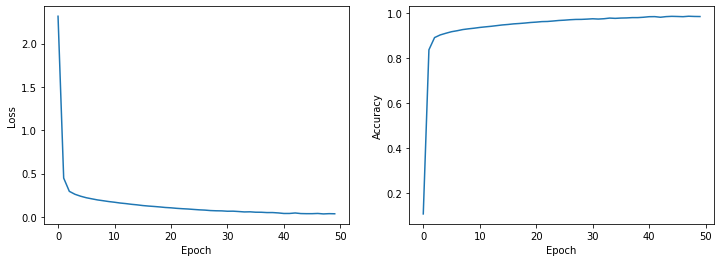

In [ ]:
image_embed_net = models.ImageEmbedNet().cuda()
image_embed_net.load_state_dict(rotation_image_embed_net.state_dict())
classify_net = models.ClassifyNet(10).cuda()
mnist_classify_model = models.ImageClassifyModel(image_embed_net, classify_net)
training.train(train_small_dataset, mnist_classify_model, 16, 50)


In [ ]:
testing.test(test_full_dataset, mnist_classify_model, 16)

Testing Accuracy: 0.906


As we can see, while training for longer on the small dataset gets perfect train accuracy, the test accuracy is no better than what we got before. Part of the benefit of having pre-trained features is greater robustness to this sort of overfitting.

# Conclusion

That's it, you are done! Remember to submit your code by .py files to the autograder.


Credits: Aspects of this notebook have been adapted from [here](https://colab.research.google.com/github/AmarSaini/Epoching-Blog/blob/master/_notebooks/2020-03-23-Self-Supervision-with-FastAI.ipynb#scrollTo=lsQmOOQsMVFT)